In [21]:
!pip install -q transformers pillow torch torchvision

In [22]:
import torch
from PIL import Image
from transformers import AutoImageProcessor, ViTForImageClassification
import requests

In [23]:
# This checkpoint is trained on ImageNet-1k at 224x224

MODEL_ID = "google/vit-base-patch16-224"

In [24]:
IMAGE_PATHS = [
            "https://t3.ftcdn.net/jpg/02/36/99/22/360_F_236992283_sNOxCVQeFLd5pdqaKGh8DRGMZy7P4XKm.jpg",
            "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT-Htw_WJAca1TO0Qhs43K3l9ZZK5WjW9zmhw&s",
            "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTBIOXUrEqayRzBQIttyKSgkk1cT4Gsyo3gjQ&s",
            "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTeKOOpLy92UjzQxq8NCxgxOQJbj_YVdfHO_g&s",
            "https://assets.epicurious.com/photos/570b9e8d671fb39e368f645d/16:9/w_2000,h_1125,c_limit/shutterstock_283253174.jpg"
]
IMAGE_TRUE_LABELS = ["cat","chair", "bus", "cat", "lime"] # Removed "dog" to match the number of processed images

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [26]:
# 4) Load processor & model
processor = AutoImageProcessor.from_pretrained(MODEL_ID)
model = ViTForImageClassification.from_pretrained(MODEL_ID).to(device)
model.eval()

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [27]:
# Inference helper
def topk_from_logits(logits, id2label, k=5):
    probs = torch.softmax(logits, dim=-1)
    top_probs, top_idxs = probs.topk(k, dim=-1)
    top_idxs = top_idxs.squeeze(0).tolist()
    top_probs = top_probs.squeeze(0).tolist()
    return [(id2label[i], float(p)) for i, p in zip(top_idxs, top_probs)]

In [28]:
import io

Predicted_Labels =[]
for path in IMAGE_PATHS:
  try:
      response = requests.get(path)
      img = Image.open(io.BytesIO(response.content)).convert("RGB")

      # Processor will resize images to 224 as the model expects
      inputs = processor(images=img, return_tensors="pt").to(device)

      with torch.no_grad():
          outputs = model(**inputs)
          logits = outputs.logits

      # Label mapping from the checkpoint
      id2label = model.config.id2label

      # Top-1 and Top-5
      top5 = topk_from_logits(logits, id2label, k=5)
      top1 = top5[0]
      Predicted_Labels.append(top1)

      print("\n" + "="*70)
      print(f"Image: {path}")
      print(f"Top-1: {top1[0]}  (p={top1[1]:.3f})")
      print("Top-5:")
      for rank, (label, p) in enumerate(top5, start=1):
          print(f"  {rank}. {label:25s}  p={p:.3f}")

  except Exception as e:
      print(f"\n[!] Skipping '{path}' — could not open or process image ({e}).")
      continue


Image: https://t3.ftcdn.net/jpg/02/36/99/22/360_F_236992283_sNOxCVQeFLd5pdqaKGh8DRGMZy7P4XKm.jpg
Top-1: tabby, tabby cat  (p=0.722)
Top-5:
  1. tabby, tabby cat           p=0.722
  2. tiger cat                  p=0.164
  3. Egyptian cat               p=0.067
  4. Persian cat                p=0.030
  5. lynx, catamount            p=0.007

Image: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT-Htw_WJAca1TO0Qhs43K3l9ZZK5WjW9zmhw&s
Top-1: rocking chair, rocker  (p=0.482)
Top-5:
  1. rocking chair, rocker      p=0.482
  2. sliding door               p=0.087
  3. studio couch, day bed      p=0.073
  4. dining table, board        p=0.036
  5. window shade               p=0.028

Image: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTBIOXUrEqayRzBQIttyKSgkk1cT4Gsyo3gjQ&s
Top-1: passenger car, coach, carriage  (p=0.538)
Top-5:
  1. passenger car, coach, carriage  p=0.538
  2. trolleybus, trolley coach, trackless trolley  p=0.403
  3. minibus                    p=0.023
  4. school

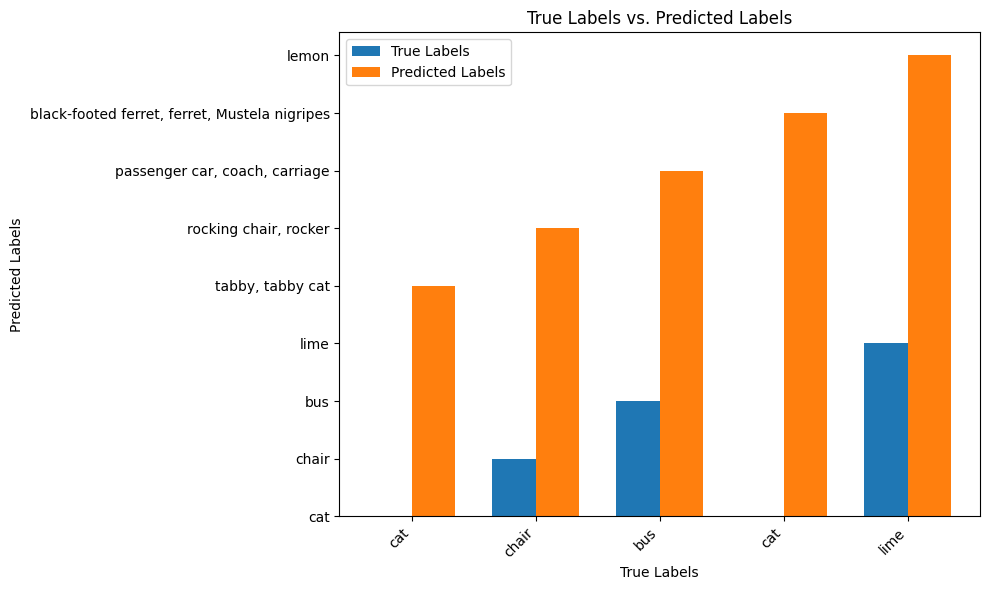

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Extracting the predicted labels from the top1 results
predicted_label = [label[0] for label in Predicted_Labels]

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(IMAGE_TRUE_LABELS))
width = 0.35 # the width of the bars

rects1 = ax.bar(x - width/2, IMAGE_TRUE_LABELS, width, label='True Labels')
rects2 = ax.bar(x + width/2, predicted_label, width, label='Predicted Labels')

ax.set_ylabel('Predicted Labels')
ax.set_title('True Labels vs. Predicted Labels')
ax.set_xticks(x)
ax.set_xticklabels([f'{IMAGE_TRUE_LABELS [i]}' for i in range(len(IMAGE_TRUE_LABELS))])
ax.legend()

plt.xticks(rotation=45, ha="right")
plt.xlabel("True Labels")
plt.tight_layout()
plt.show()

In [31]:
import requests
from PIL import Image
from io import BytesIO
import os

if not os.path.exists("downloaded_images"):
    os.makedirs("downloaded_images")

downloaded_image_paths = []
for i, url in enumerate(IMAGE_PATHS):
    try:
        response = requests.get(url)
        response.raise_for_status()
        img = Image.open(io.BytesIO(response.content)).convert("RGB")
        filename = os.path.join("downloaded_images", f"image_{i+1}.jpg")
        img.save(filename)
        downloaded_image_paths.append(filename)
        print(f"Downloaded {url} to {filename}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
    except Exception as e:
        print(f"Error processing image from {url}: {e}")

print("\nDownloaded images are saved in the 'downloaded_images' directory.")
print("List of downloaded image paths:", downloaded_image_paths)

Downloaded https://t3.ftcdn.net/jpg/02/36/99/22/360_F_236992283_sNOxCVQeFLd5pdqaKGh8DRGMZy7P4XKm.jpg to downloaded_images/image_1.jpg
Downloaded https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT-Htw_WJAca1TO0Qhs43K3l9ZZK5WjW9zmhw&s to downloaded_images/image_2.jpg
Downloaded https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTBIOXUrEqayRzBQIttyKSgkk1cT4Gsyo3gjQ&s to downloaded_images/image_3.jpg
Downloaded https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTeKOOpLy92UjzQxq8NCxgxOQJbj_YVdfHO_g&s to downloaded_images/image_4.jpg
Downloaded https://assets.epicurious.com/photos/570b9e8d671fb39e368f645d/16:9/w_2000,h_1125,c_limit/shutterstock_283253174.jpg to downloaded_images/image_5.jpg

Downloaded images are saved in the 'downloaded_images' directory.
List of downloaded image paths: ['downloaded_images/image_1.jpg', 'downloaded_images/image_2.jpg', 'downloaded_images/image_3.jpg', 'downloaded_images/image_4.jpg', 'downloaded_images/image_5.jpg']


In [2]:
import os, io, math, random, json, warnings
from typing import Optional, Tuple

from torchvision import transforms

# Transformers (may need internet to download the model/processor the first time)
try:
    from transformers import AutoImageProcessor, ViTForImageClassification, ViTConfig
except Exception as e:
    raise RuntimeError("Transformers is required. Please run the install cell above and restart the kernel.") from e

# Reproducibility helpers
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # Determinism (okay to omit if you prefer speed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


In [3]:
# Default model trained on ImageNet-1k at 224x224, 16x16 patches
MODEL_ID = "google/vit-base-patch16-224"
IMAGE_SIZE = 224  # used if we fallback to manual preprocessing
PATCH_SIZE = 16   # for vit-base-patch16-224 the grid is 14x14

In [4]:
import requests

def load_image(source: str) -> Image.Image:
    """
    Load an RGB image from a local file path or a URL.
    """
    if source.lower().startswith("http"):
        try:
            resp = requests.get(source, stream=True, timeout=10)
            resp.raise_for_status()
            img = Image.open(resp.raw).convert("RGB")
            return img
        except Exception as e:
            raise RuntimeError(f"Could not fetch remote image: {e}")
    else:
        if not os.path.exists(source):
            raise FileNotFoundError(f"Local file not found: {source}")
        return Image.open(source).convert("RGB")

In [5]:
_processor = None

def get_processor():
    global _processor
    if _processor is not None:
        return _processor
    try:
        _processor = AutoImageProcessor.from_pretrained(MODEL_ID)
        print("Using AutoImageProcessor:", MODEL_ID)
    except Exception as e:
        print("[WARN] AutoImageProcessor download failed.", e)
        _processor = None
    return _processor


def preprocess(image: Image.Image) -> torch.Tensor:
    proc = get_processor()
    inputs = proc(images=image, return_tensors="pt")
    return inputs["pixel_values"]


In [6]:
# Model loading
# We prefer pretrained; if that fails (e.g., offline), we instantiate from config (random weights).
_model = None

def get_model(output_attentions: bool = True):
    global _model
    if _model is not None:
        return _model

    try:
        model = ViTForImageClassification.from_pretrained(MODEL_ID, output_attentions=output_attentions)
        print("Loaded pretrained model:", MODEL_ID)
    except Exception as e:
        print("[WARN] Pretrained model download failed. Falling back to random-initialized config. Error:", e)


    _model = model.to(device).eval()
    return _model

In [7]:
# Inference (returns logits and attentions)
@torch.no_grad()
def forward_with_attn(image: Image.Image):
    model = get_model(output_attentions=True)
    pixels = preprocess(image).to(device)  # (1,3,H,W) or processor tensor
    outputs = model(pixels)
    logits = outputs.logits              # (1, num_classes)
    atts = outputs.attentions            # tuple of (num_layers) each (1, heads, seq, seq)
    return logits, atts

In [15]:
#) Attention visualization utilities
def cls_attention_last_layer(attentions) -> torch.Tensor:
    """
    Extract the last layer attention from CLS token to patch tokens.
    Returns a (H, grid, grid) tensor where H is number of heads (averaged later if desired).
    """
    # attentions: tuple of layers; each [B, heads, seq, seq]
    last = attentions[-1]          # (1, heads, seq, seq)
    last = last[0]                 # (heads, seq, seq)
    heads, seq, _ = last.shape
    # CLS token is index 0; attention from CLS to all tokens is last[:, 0, :]
    cls_to_all = last[:, 0, :]     # (heads, seq)
    # Drop the CLS token itself and keep only patch tokens
    patch = cls_to_all[:, 1:]      # (heads, seq-1)
    # For vit-base-patch16-224, seq-1 should be 14*14 = 196
    grid_size = int(math.sqrt(patch.shape[-1]))
    if grid_size * grid_size != patch.shape[-1]:
        raise RuntimeError(f"Patch count {patch.shape[-1]} is not a perfect square; cannot reshape to grid.")
    patch = patch.reshape(heads, grid_size, grid_size)   # (heads, 14, 14) for 224/16
    return patch

def overlay_heatmap_on_image(img: Image.Image, heatmap_2d: np.ndarray, alpha: float = 0.5) -> Image.Image:
    """
    Overlay a 2D heatmap (0..1) onto a PIL image (resized to match). Returns a PIL image.
    """
    heat = (heatmap_2d - heatmap_2d.min()) / (np.ptp(heatmap_2d) + 1e-8)
    heat_img = Image.fromarray(np.uint8(plt.cm.jet(heat) * 255))  # RGBA
    heat_img = heat_img.convert("RGBA").resize(img.size, Image.BICUBIC)
    base = img.convert("RGBA")
    blended = Image.blend(base, heat_img, alpha=alpha)
    return blended.convert("RGB")

def show_attention_map(img: Image.Image, attn_heads: torch.Tensor, aggregate: str = "mean", save_path: Optional[str] = None):
    """
    attn_heads: (heads, H, W). aggregate in {"mean", "max"} across heads.
    """
    if aggregate == "mean":
        attn_2d = attn_heads.mean(0).cpu().numpy()
    elif aggregate == "max":
        attn_2d = attn_heads.max(0).values.cpu().numpy()
    else:
        raise ValueError("aggregate must be 'mean' or 'max'")
    blended = overlay_heatmap_on_image(img, attn_2d, alpha=0.45)

    plt.figure(figsize=(5,5))
    plt.imshow(blended)
    plt.axis("off")
    if save_path:
        blended.save(save_path)
        print("Saved attention overlay to:", save_path)
    plt.show()

Processing image: downloaded_images/image_1.jpg
Logits shape: torch.Size([1, 1000])
Saved attention overlay to: attention_maps/attention_map_1.jpg


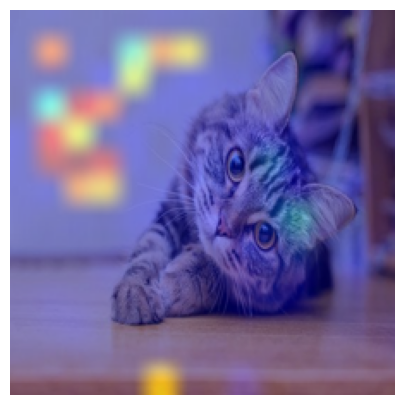

Processing image: downloaded_images/image_2.jpg
Logits shape: torch.Size([1, 1000])
Saved attention overlay to: attention_maps/attention_map_2.jpg


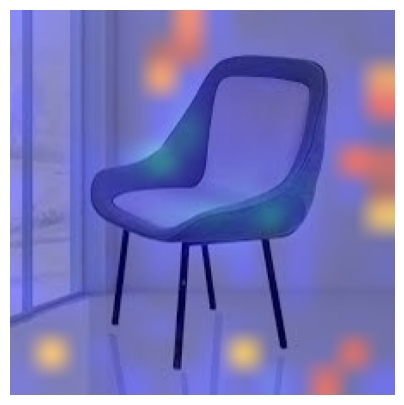

Processing image: downloaded_images/image_3.jpg
Logits shape: torch.Size([1, 1000])
Saved attention overlay to: attention_maps/attention_map_3.jpg


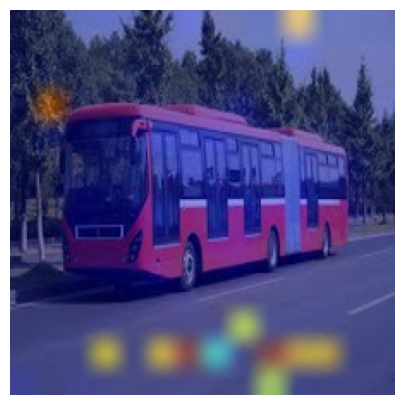

Processing image: downloaded_images/image_4.jpg
Logits shape: torch.Size([1, 1000])
Saved attention overlay to: attention_maps/attention_map_4.jpg


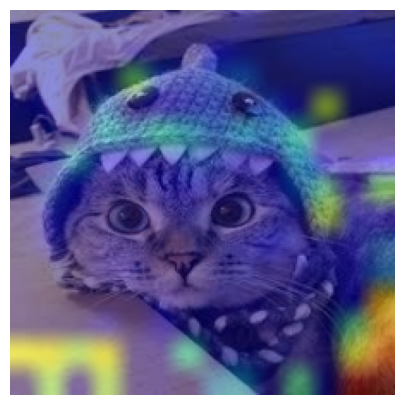

Processing image: downloaded_images/image_5.jpg
Logits shape: torch.Size([1, 1000])
Saved attention overlay to: attention_maps/attention_map_5.jpg


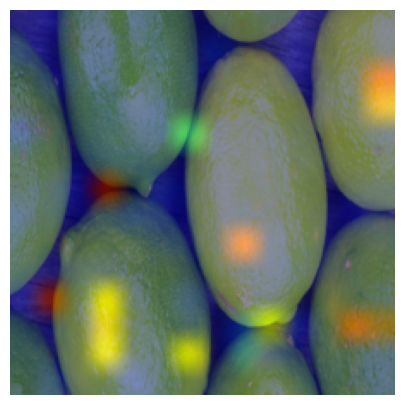

In [20]:
# Create a directory to save attention maps
attention_map_dir = "attention_maps"
if not os.path.exists(attention_map_dir):
    os.makedirs(attention_map_dir)

# Process all downloaded images
for i, img_path in enumerate(downloaded_image_paths):
    if os.path.exists(img_path):
        print(f"Processing image: {img_path}")
        try:
            img = Image.open(img_path).convert("RGB")
            logits, atts = forward_with_attn(img)
            print("Logits shape:", logits.shape)
            heads_grid = cls_attention_last_layer(atts)  # (heads, 14, 14) for vit-base-patch16-224
            # Resize image for consistent display if needed, though show_attention_map resizes the heatmap
            save_filename = os.path.join(attention_map_dir, f"attention_map_{i+1}.jpg")
            show_attention_map(img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.BICUBIC), heads_grid, aggregate="mean", save_path=save_filename)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    else:
        print(f"[INFO] Image path not found: {img_path}")